# Fine-Tuning on NT5 Multitask Training
Authors:   
Aditya Todi, atodi@cs.stonybrook.edu  
Omkar Kanade, okanade@cs.stonybrook.edu  
Samruddhi Patil, sampatil@cs.stonybrook.edu

## Setup
The section includes all the global parameters and codes to set up the environment for the NT5 training pipeline.

In [1]:
if 'colab' in str(get_ipython()):
    import google.colab as colab
    from IPython.display import clear_output

    colab.auth.authenticate_user()
    colab.drive.mount('/content/gdrive') # mount google drive

    !pip install tensorflow-text
    !pip install transformers
    !pip install datasets
    !pip install tqdm
    !pip install --pre allennlp-models

    clear_output() 

In [1]:
# ml libraries
from __future__ import print_function

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import transformers
import datasets # https://huggingface.co/docs/datasets/

# for allennlp, if you did a pip install on colab, restart the runtime
from allennlp.common.testing import (
                                AllenNlpTestCase,
                                global_distributed_metric,
                                run_distributed_test)
from allennlp_models.rc.metrics import DropEmAndF1

# data processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from google.cloud import storage as gcs

# other libraries
import os
import json
import functools
import time
import math
import warnings
import string
import re
import argparse
import pickle
from collections import Counter
from datetime import datetime
from IPython.display import clear_output

# plot libs
import matplotlib.pyplot as plt

print(f'TensorFlow {tf.__version__}')

TensorFlow 2.11.0


In [3]:
PROCESSOR = 'GPU'
EVALUATE_DEV = True
EVALUATE_TEST = False

# ------------------------------------------------------------------------------
# SEMSITIVE PRIVATE INFO

# path to repo on gdrive
# gdrive is used to save/load csv (e.g. performance evaluation reports) and model files 
GDRIVE_REPO_PATH='/content/gdrive/Shareddrives/NLP - Op tASk/NLP NRot Improvement/numeric-t5'


# gcp storage paths
DROP_PATH_GCP = '/content/gdrive/Shareddrives/NLP - Op tASk/NLP NRot Improvement/numeric-t5/datasets'

# token for wandb, training results tracker
WAND_LOGIN_TOKEN = ''

# ------------------------------------------------------------------------------
# T5 NONSTOP TRAINING CONFIGS

# "t5-small": "https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json"
# "t5-base": "https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json"
# "t5-large": "https://s3.amazonaws.com/models.huggingface.co/bert/t5-large-config.json"
# "t5-3b": "https://s3.amazonaws.com/models.huggingface.co/bert/t5-3b-config.json"
# "t5-11b": "https://s3.amazonaws.com/models.huggingface.co/bert/t5-11b-config.json"
T5_MODEL = 't5-small'
EPOCHS = 2

# ------------------------------------------------------------------------------
# T5 CONTINUOUS TRAINING CONFIGS
# NOTE: Do NOT confuse "continuous training" with "stage training." "Continuous 
# training" in this notebook refers to the scenarion where the full traning schedule 
# (e.g. 60 epochs) for the SAME dataset is broken in to multiple sub trainng schedules 
# (e.g. two 30-epochs training). "Stage training" refers to a new training schedule
# thatfor a new dataset, although the training can be on top of a model that has been
# trained on other datasets. For example, each stage of the following training schedule
# is a stage: NUMERICAL DATASET -> TEXTUAL DATASET -> SQUAD -> DROP. "Continous
# training" can take place when the 60-epoch training schedule on NUMERICAL DATASET is 
# broken into two 30-epoch training schedules.

# doit: set to true ONLY IF continue training for the SAME dataset
# epoch_total defines the total number of epochs for the entire training schedule
# epoch_start defines the starting # of epoch for the current training
# epoch_end defines the ending # of epoch for the current training
EPOCHS_CONTINUE = {'doit': False, 
                   'epoch_total': 60,
                   'epoch_start': 16,
                   'epoch_end': 30}

# ------------------------------------------------------------------------------
# DATASET CONFIGS

# MUSIQUE DATASET
MUSIQUE_TRAIN_TFREC = os.path.join(DROP_PATH_GCP, 'musique/musique_train.tfrecord')
MUSIQUE_DEV_TFREC = os.path.join(DROP_PATH_GCP, 'musique/musique_dev.tfrecord')
MUSIQUE_TRAIN_EXAMPLE_COUNT = 39876
MUSIQUE_DEV_EXAMPLE_COUNT = 4834
MUSIQUE_TRAIN_JSON = os.path.join(DROP_PATH_GCP, 'musique/musique_train.json')
MUSIQUE_DEV_JSON = os.path.join(DROP_PATH_GCP, 'musique/musique_dev.json')

# DROP DATASET  
DROP_TRAIN_TFREC = os.path.join(DROP_PATH_GCP, 'drop/drop_dataset_train_v4_77400.tfrecord')
DROP_DEV_TFREC = os.path.join(DROP_PATH_GCP, 'drop/drop_dataset_dev_v4_9536.tfrecord')
DROP_TRAIN_EXAMPLE_COUNT = 77400
DROP_DEV_EXAMPLE_COUNT = 9536
DROP_DEV_JSON = os.path.join(DROP_PATH_GCP, 'drop/drop_dataset_dev.json')
DROP_TEST_JSON = os.path.join(DROP_PATH_GCP, 'drop/drop_dataset_test_questions.json')

# DROP CATEGORY DATASET
DROP_CATEGORY_TRAIN_TFREC = os.path.join(DROP_PATH_GCP, 'drop/drop_dataset_train_v4_cat_77400.tfrecord')
DROP_CATEGORY_DEV_TFREC = os.path.join(DROP_PATH_GCP, 'drop/drop_dataset_dev_v4_cat_9536.tfrecord')
DROP_CATEGORY_TRAIN_EXAMPLE_COUNT = 77400
DROP_CATEGORY_DEV_EXAMPLE_COUNT = 9536

# NUMERICAL DATASET
SYN_NUM_TRAIN_TFREC = os.path.join(DROP_PATH_GCP, 'numeric/numeric_train_data_parsed_v2_990000.tfrecord')
SYN_NUM_DEV_TFREC = os.path.join(DROP_PATH_GCP, 'numeric/numeric_dev_data_parsed_v2_9996.tfrecord')
SYN_NUM_TRAIN_EXAMPLE_COUNT = 990000
SYN_NUM_DEV_EXAMPLE_COUNT = 9996

SQUAD_TRAIN_TFREC = os.path.join(DROP_PATH_GCP, 'squad/squad1.1_train_data_parsed_v3_87599.tfrecord')
SQUAD_DEV_TFREC = os.path.join(DROP_PATH_GCP, 'squad/squad1.1_dev_data_parsed_v3_10570.tfrecord')
SQUAD_TRAIN_EXAMPLE_COUNT = 87599
SQUAD_DEV_EXAMPLE_COUNT = 10570

# TEXTUAL DATASET
SYN_TXT_TRAIN_TFREC = os.path.join(DROP_PATH_GCP, 'textual/textual_train_data_parsed_v2_2523192.tfrecord')
SYN_TXT_DEV_TFREC = os.path.join(DROP_PATH_GCP, 'textual/textual_dev_data_parsed_v2_10000.tfrecord')
SYN_TXT_TRAIN_EXAMPLE_COUNT = 2523192
SYN_TXT_DEV_EXAMPLE_COUNT = 10000

# ------------------------------------------------------------------------------
# TRAINING CONFIGS

# BASIC SETUP
BATCH_SIZE = 32
ENCODER_MAX_LEN = 512 # must be consistent with configs used to build TFRecords
DECODER_MAX_LEN = 54 # must be consistent with configs used to build TFRecords
TOKENIZER = transformers.AutoTokenizer.from_pretrained(T5_MODEL)
special_tokens_dict = {'additional_special_tokens': ['0','1','2','3', '4', '5', '6', '7', '8', '9', '<ss>', '<sv>']}
num_added_toks = TOKENIZER.add_special_tokens(special_tokens_dict)

# DATASET MIXTURE CONFIGS
IS_TRAIN_DS_MIXTURE = False
MIXTURE_TEMP = 1
MIXTURE_MAX = None
MIXTURE_SCALE = 1

# TRAINING STEPS
if IS_TRAIN_DS_MIXTURE:
    # mixture
    VALID_TOTAL_EXAMPLE_COUNT = SYN_TXT_DEV_EXAMPLE_COUNT
    VALID_STEPS = math.ceil(VALID_TOTAL_EXAMPLE_COUNT / BATCH_SIZE)
    TRAIN_STEPS = None # train steps will be updated after ds is loaded with the predefined tempature
else:
    # single ds
    TRAIN_TOTAL_EXAMPLE_COUNT = DROP_TRAIN_EXAMPLE_COUNT
    VALID_TOTAL_EXAMPLE_COUNT = DROP_DEV_EXAMPLE_COUNT
    TRAIN_STEPS = math.ceil(TRAIN_TOTAL_EXAMPLE_COUNT / BATCH_SIZE)
    VALID_STEPS = math.ceil(VALID_TOTAL_EXAMPLE_COUNT / BATCH_SIZE)    

# ------------------------------------------------------------------------------
# LARNING RATE CONFIGS

LR_DO_WARMUP_DECAY = True
LR_CONSTANT = 0.001 # constant lr will be used if LR_DO_WARMUP_DECAY is set to False
LR_WARMUP_START = 1e-8 # lr for the 1st epoch
LR_WARMUP_END = 1e-4
LR_MIN = LR_WARMUP_START
LR_DECAY_RATE_LINEAR = 0.001
if EPOCHS >= 10:
    # allocate 10% of training steps to warmup
    WARMP_UP_EPOCHS = EPOCHS / 10 
else:
    # just for testing
    WARMP_UP_EPOCHS = 1

# ------------------------------------------------------------------------------
# MODEL SAVING CONFIGS

SAVE_TRAINED_MODEL = True

SAVE_MODEL_WEIGHTS_ONLY = True
SAVE_MODEL_CHECKPOINTS_LOCAL = True
SAVE_MODEL_CHECKPOINTS_WANDB = False
SAVE_BEST_MODEL_ONLY = True
TENSORBOARD_LOG_PATH = f'{GDRIVE_REPO_PATH}/logs'
MODEL_SAVE_PATH = f'{GDRIVE_REPO_PATH}/models'
SHOW_TENSORBOARD = False
SHOW_WANDB = False
WANDB_PROJECT_NAME = 't5-numerical-reasoning'

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [17]:
# ref: https://www.tensorflow.org/guide/tpu
if PROCESSOR == "TPU":
    print("connecting to TPU...")
    try:
        # 'grpc://' + os.environ['COLAB_TPU_ADDR']
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU: ', tpu.get_master())
    except ValueError:
        print("Error: Unable to connect to TPU...")
        tpu = None

    if tpu:
        try:
            print("Initializing TPU...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu) # tf 2.3.x
            print("TPU initialized!")
        except:
            print("Error: Failed to initialize TPU...")
    else:
        PROCESSOR = "GPU"

if PROCESSOR != "TPU":
    print("Using default strategy for CPU/GPU...")
    strategy = tf.distribute.get_strategy()

if PROCESSOR == "GPU":
    # ref: https://tinyurl.com/yxddsxxq
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # memory growth must be set before GPUs have been initialized
            print(e)

Using default strategy for CPU/GPU...
1 Physical GPUs, 1 Logical GPUs


## Dataset Prep
The section provides functions and codes to prepare the datasets for training.

In [18]:
def prep_tfrec_ds(
            tfrec_path: str, 
            batch_size: int = BATCH_SIZE,
            repeat: bool = True,
            shuffle: bool = True,
            processor: str = PROCESSOR,
            encoder_max_len: int = ENCODER_MAX_LEN,
            decoder_max_len: int = DECODER_MAX_LEN,
            mode: str = 'train') -> tf.data.TFRecordDataset:

    if mode == 'train':
        features_description = {
            'input_ids': tf.io.FixedLenFeature([ENCODER_MAX_LEN], tf.int64),
            'attention_mask': tf.io.FixedLenFeature([ENCODER_MAX_LEN], tf.int64), 
            'labels': tf.io.FixedLenFeature([DECODER_MAX_LEN], tf.int64),
            'decoder_attention_mask': tf.io.FixedLenFeature([DECODER_MAX_LEN], tf.int64)
        }
    else:
        features_description = {
            'input_ids': tf.io.FixedLenFeature([ENCODER_MAX_LEN], tf.int64),
            'attention_mask': tf.io.FixedLenFeature([ENCODER_MAX_LEN], tf.int64), 
            'labels': tf.io.FixedLenFeature([DECODER_MAX_LEN], tf.int64),
            'decoder_attention_mask': tf.io.FixedLenFeature([DECODER_MAX_LEN], tf.int64),
            'answer_type': tf.io.FixedLenFeature([1], tf.string),
            'query_id': tf.io.FixedLenFeature([1], tf.string),
            'validated_answers': tf.io.FixedLenFeature([1], tf.string)
        }

    ds = tf.data.TFRecordDataset(
                        tfrec_path, 
                        num_parallel_reads=tf.data.experimental.AUTOTUNE)
    ds = ds.map(lambda batch_seralized: tf.io.parse_example(
                                                batch_seralized, 
                                                features_description),
                                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if shuffle: 
        ds = ds.shuffle(buffer_size=1024) # 1024 to optimize TPU performance
    ds = ds.repeat(-1) if repeat else ds.repeat(1)
    ds = ds.batch(batch_size)

    # From tf doc (https://tinyurl.com/yavczqkr):
    # Most dataset input pipelines should end with a call to prefetch. This allows 
    # later elements to be prepared while the current element is being processed. This 
    # often improves latency and throughput, at the cost of using additional memory to 
    # store prefetched elements.
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    # https://tinyurl.com/yao4obsb
    # A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
    # Therefore, for efficient utilization of Cloud TPU, a program should make use of 
    # each of the eight cores.
    #
    # https://tinyurl.com/y99kjyh5
    # Model processing performance
    # For optimum memory usage, use the largest batch size that will fit in memory. 
    # Each TPU core uses a 128 x 128 memory cell matrix for processing. In general, 
    # your batch sized should be evenly divisible by 128 to most effectively use the TPU memory.
    #
    # https://tinyurl.com/yawn2acn
    # Batch Size Too Small
    # The batch size of any model should always be at least 64 (8 per TPU core) 
    # because TPU always pads the tensors to this size. The ideal batch size when 
    # training on the TPU is 1024 (128 per TPU core), since this eliminates inefficiencies 
    # related to memory transfer and padding.
    #
    # https://tinyurl.com/y9nojpa2
    # Minimal requirement: A multiple of 8!
    if processor == 'TPU':
        if batch_size < 64:
            # better
            print('Warning: Batch size {} is smaller than 64...'.format(batch_size))
        if batch_size % 8 > 0:
            # min requirement
            print('Warning: Batch size {} is not a multiple of 8...'.format(batch_size))
        
    return ds

def prep_multitask_tfrec_ds(
                    tfrec_paths: list, # path is now a list object
                    tfrec_example_counts: list = [],
                    batch_size: int = BATCH_SIZE,
                    repeat: bool = True,
                    shuffle: bool = True,
                    processor: str = PROCESSOR,
                    encoder_max_len: int = ENCODER_MAX_LEN,
                    decoder_max_len: int = DECODER_MAX_LEN):

    datasets = []
    dataset_lengths = []
    if len(tfrec_example_counts) == len(tfrec_paths):
        dataset_lengths = tfrec_example_counts
    else:
        dataset_lengths = []

    # iterate datasets to:
    # 1. grab length from file name, xyz_1234.tfrecord -> 1234
    # 2. read in to list
    for i, path in enumerate(tfrec_paths):
        file_name = os.path.basename(path)

        # compute & store number of examples in tfrec
        if len(tfrec_example_counts) != len(tfrec_paths):
            length = int(re.search(r'_(\d+)\.', file_name).group(1))
            dataset_lengths.append(length)

        # prep each individual ds
        ds = tf.data.TFRecordDataset(
                            path, 
                            num_parallel_reads=tf.data.experimental.AUTOTUNE)
        if shuffle: 
            ds = ds.shuffle(buffer_size=1024)
        datasets.append(ds.repeat())
        
    # calculate sampling weights
    print("Dataset lengths:", dataset_lengths)
    dataset_weights = temperature_to_weights(dataset_lengths)
    print("Ratio:", dataset_weights)
    # sample from datasets for a mixture dataset
    ds = tf.data.experimental.sample_from_datasets(
                                                datasets, 
                                                weights=dataset_weights)

    # prep consolidated ds
    features_description = {
        'input_ids': tf.io.FixedLenFeature([ENCODER_MAX_LEN], tf.int64),
        'attention_mask': tf.io.FixedLenFeature([ENCODER_MAX_LEN], tf.int64), 
        'labels': tf.io.FixedLenFeature([DECODER_MAX_LEN], tf.int64),
        'decoder_attention_mask': tf.io.FixedLenFeature([DECODER_MAX_LEN], tf.int64),
    }
    ds = ds.map(lambda batch_seralized: tf.io.parse_example(
                                                batch_seralized, 
                                                features_description),
                                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    if processor == 'TPU':
        if batch_size < 64:
            # better
            print('Warning: Batch size {} is smaller than 64...'.format(batch_size))
        if batch_size % 8 > 0:
            # min requirement
            print('Warning: Batch size {} is not a multiple of 8...'.format(batch_size))
    
    min_size_index = np.argmin(dataset_lengths)
    min_size = dataset_lengths[min_size_index]
    min_size_sampling_weight = dataset_weights[min_size_index]
    scale = float(min_size) / min_size_sampling_weight
    max_ds_size = [scale * i for i in dataset_weights]
    print("Max sampled sizes:", max_ds_size)
    
    return ds, max_ds_size

def temperature_to_weights(
            dataset_lengths: list, 
            temperature: float = MIXTURE_TEMP, 
            maximum: bool = MIXTURE_MAX, 
            scale: float = MIXTURE_SCALE) -> list:
    '''Calculate renormalized mixing rates
       this is the rates at which the datasets are sampled
    '''
    mixing_rates = []
    for length in dataset_lengths:
        rate = length * scale
        if maximum:
            rate = min(rate, maximum)
        if temperature != 1.0:
            rate = rate ** (1.0/temperature)
        mixing_rates.append(rate)
    mixing_rates = [float(rate)/sum(mixing_rates) for rate in mixing_rates]
    return mixing_rates

In [19]:
if IS_TRAIN_DS_MIXTURE:
    # load/prep multitasking ds
    train_ds, max_ds_size = prep_multitask_tfrec_ds([DROP_TRAIN_TFREC, DROP_CATEGORY_TRAIN_TFREC])
    val_ds, max_ds_valid_size = prep_multitask_tfrec_ds([DROP_DEV_TFREC, DROP_CATEGORY_DEV_TFREC])

    # update the global constants
    TRAIN_STEPS = math.ceil(int(sum(max_ds_size)) / BATCH_SIZE)
    VALID_STEPS = math.ceil(int(sum(max_ds_valid_size)) / BATCH_SIZE)

else:
    # load/prep a single ds
    train_ds, max_ds_size = prep_multitask_tfrec_ds(
                                tfrec_paths=[MUSIQUE_TRAIN_TFREC],
                                tfrec_example_counts=[MUSIQUE_TRAIN_EXAMPLE_COUNT])
    val_ds = prep_tfrec_ds(MUSIQUE_DEV_TFREC)

print(f'Train Steps: {TRAIN_STEPS}, Valid Steps: {VALID_STEPS}')

Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Dataset lengths: [39876]
Ratio: [1.0]
Max sampled sizes: [39876.0]
Train Steps: 2419, Valid Steps: 298


In [20]:
# set to true to print example counts for training and dev sets
PRINT_EXAMPLE_COUNT = True

if PRINT_EXAMPLE_COUNT:
    def count_examples_in_tfrec(tfrec_path: str) -> int:
        return sum(1 for _ in tf.data.TFRecordDataset(tfrec_path))

    print(f'# of examples in {MUSIQUE_TRAIN_TFREC}: {count_examples_in_tfrec(MUSIQUE_TRAIN_TFREC)}')
    print(f'DROP_TRAIN_EXAMPLE_COUNT = {MUSIQUE_TRAIN_EXAMPLE_COUNT}')
    print('')
    print(f'# of examples in {MUSIQUE_DEV_TFREC}: {count_examples_in_tfrec(MUSIQUE_DEV_TFREC)}')
    print(f'DROP_DEV_EXAMPLE_COUNT = {MUSIQUE_DEV_EXAMPLE_COUNT}')

# of examples in /content/gdrive/Shareddrives/NLP - Op tASk/NLP NRot Improvement/numeric-t5/datasets/musique/musique_train.tfrecord: 19938
DROP_TRAIN_EXAMPLE_COUNT = 39876

# of examples in /content/gdrive/Shareddrives/NLP - Op tASk/NLP NRot Improvement/numeric-t5/datasets/musique/musique_dev.tfrecord: 2417
DROP_DEV_EXAMPLE_COUNT = 4834


## Training
In this section, we build the pipeline for training. 

In [24]:
class DROPBaseT5(transformers.TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir: str = None, cache_dir: str = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss')

    # Notes from doc:
    # When you need to customize what fit() does, you should override the training 
    # step function of the Model class. This is the function that is called by fit() 
    # for every batch of data. You will then be able to call fit() as usual -- and 
    # it will be running your own learning algorithm.
    @tf.function
    def train_step(self, data: datasets.Dataset) -> dict:
        # required for eager execution when customzing the the training loops
        with tf.GradientTape() as tape:
            # forward pass; equivalent of pushing the input x through the entire 
            # neural network for a prediction
            # Note:
            # "self" is a reference to TFT5ForConditionalGeneration, which is a 
            # subclass of keras.Model, which returns a reference to a function.
            # https://tinyurl.com/yx9qvmyf
            # https://keras.io/guides/customizing_what_happens_in_fit/
            # https://huggingface.co/transformers/model_doc/t5.html#tft5forconditionalgeneration
            # outputs = self(data, training=True) 
            print(data["input_ids"])
            outputs = super().call(
                        input_ids=data["input_ids"],
                        labels=data["labels"],
                        attention_mask=data["attention_mask"],
                        decoder_attention_mask=data["decoder_attention_mask"],
                        training=True)
        
            # record the gradient
            # output of hugging face is a tuple: (outputs.loss, outputs.logits)
            # https://huggingface.co/transformers/main_classes/output.html 
            loss = tf.reduce_mean(outputs[0])
            grads = tape.gradient(loss, self.trainable_variables)
        
        # optimizer as defined through Keras' API when compiling the model
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        # track metrics
        y = tf.reshape(data["labels"], [-1, 1])
        y_pred_logits = outputs[1]
        # lr = self.optimizer._decayed_lr(tf.float32)
        self.loss_tracker.update_state(loss)        
        self.compiled_metrics.update_state(data["labels"], y_pred_logits)
        metrics = {m.name: m.result() for m in self.metrics}
        # metrics.update({'lr': lr})
        metrics.update({'loss': loss})
        
        return metrics

    @tf.function
    def test_step(self, data: datasets.Dataset) -> dict:
        outputs = self(data, training=True) 
        y_pred_logits = outputs[1]
        loss = outputs[0]

        # compute loss
        loss = tf.reduce_mean(loss)
        self.loss_tracker.update_state(loss)

        # update metrics
        y = tf.reshape(data["labels"], [-1, 1])
        self.compiled_metrics.update_state(y, y_pred_logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'loss': loss})

        return metrics
    
    @tf.function
    def reset_f1(self) -> dict:
        print('Reset F1...')

class LRScheduler(keras.callbacks.Callback):
    """Performing custom learning rate scheduling by extending Keras' Callback.
    """

    def __init__(
            self, 
            warmup_batches      : int = TRAIN_STEPS * WARMP_UP_EPOCHS, 
            lr_warmup_start     : float = LR_WARMUP_START, 
            lr_warmup_end       : float = LR_WARMUP_END, 
            lr_min              : int = LR_MIN,
            decay_rate          : float = LR_DECAY_RATE_LINEAR,
            verbose             : int = 1):
        super(LRScheduler, self).__init__()

        # warm-up
        self.__warmup_batches = warmup_batches
        self.__lr_warmup_start = lr_warmup_start
        self.__lr_warmup_end = lr_warmup_end
        self.__lr_warmup_increment = (self.__lr_warmup_end - self.__lr_warmup_start) / self.__warmup_batches
        self.__is_warmup = True

        # decay
        self.__decay_rate = decay_rate
        self.__lr_min = lr_min

        # other properties
        self.__verbose = verbose
        self.__batch_count = 0
        self.__lr_warmup_arr = [] # by training step
        self.__lr_epoch_arr = [] # by training epoch
        
        self.__lr = 0
        self.__epoch = 0
        self.__warmup_epoch_last = 0 # epoch number where warmup ends

    def on_batch_begin(self, batch, logs=None) -> None:
        if self.__is_warmup:
            if self.__batch_count <= self.__warmup_batches: 
                self.__lr = self.__batch_count * self.__lr_warmup_increment + self.__lr_warmup_start
                K.set_value(self.model.optimizer.lr, self.__lr)
                self.__lr_warmup_arr.append(self.__lr)
                self.__batch_count  += 1

                if self.__verbose > 0:
                    print(f'\nWarm-up LR {self.__lr} at batch {self.__batch_count}...')                
            
    def on_batch_end(self, batch, logs=None) -> None:
        if self.__is_warmup:
            # end of warmup
            if self.__batch_count > self.__warmup_batches: 
                self.__warmup_epoch_last = self.__epoch
                self.__is_warmup = False

    def on_epoch_begin(self, epoch, logs=None) -> None:
        self.__epoch = epoch
        if self.__is_warmup:
            # hard code the lr calculation because on_batch_end for the first
            # batch of the epoch happens right after on_epoch_begin
            lr = self.__batch_count * self.__lr_warmup_increment + self.__lr_warmup_start    
            self.__lr_epoch_arr.append(lr)
            return
        
        self.__lr = K.get_value(self.model.optimizer.lr)
        if self.__lr <= self.__lr_min:
            K.set_value(self.model.optimizer.lr, self.__lr)
            self.__lr_epoch_arr.append(K.get_value(self.model.optimizer.lr))
            return

        lr_new = self.__lr * 1 / (1 + self.__decay_rate * (epoch - self.__warmup_epoch_last))
        K.set_value(self.model.optimizer.lr, lr_new)
        self.__lr = K.get_value(self.model.optimizer.lr) # pull lr from optimizer to confirm
        self.__lr_epoch_arr.append(self.__lr)

    def simulate_lr(
            self, 
            steps_simulation: int = 1000,
            steps_per_epoch: int = TRAIN_STEPS,
            plot: bool = True) -> list:
        # hard code a model for simulation
        # note: self.model is accessible through tf in production
        self.model = DROPBaseT5.from_pretrained(T5_MODEL)
        self.model.compile(optimizer=keras.optimizers.Adam())

        # simulate training
        for global_step in range(steps_simulation):
            batch_n = global_step % steps_per_epoch
            if batch_n == 0:
                self.on_epoch_begin(global_step // steps_per_epoch)
            self.on_batch_begin(batch_n)
            self.on_batch_end(batch_n)

        if plot:
            # plot warmup lr
            x = range(1, len(self.__lr_warmup_arr) + 1)
            print('')
            print(f'Steps per epoch: {steps_per_epoch}')
            fig, ax = plt.subplots(figsize=(15, 6))
            ax.set_title(f'LR Warmup Schedule ({self.__warmup_batches:.0f} warm-up batches)', fontsize=14, pad=11)
            ax.set_ylabel('Learning Rate')
            ax.set_xlabel('Batch Step')
            ax.plot(x, self.__lr_warmup_arr)
            plt.show()

            # plot epoch lr
            x = range(1, len(self.__lr_epoch_arr) + 1)
            print('')
            fig, ax = plt.subplots(figsize=(15, 6))
            ax.set_title(f'LR Epoch Schedule', fontsize=14, pad=11)
            ax.set_ylabel('Learning Rate')
            ax.set_xlabel('Epoch')
            ax.plot(x, self.__lr_epoch_arr)
            print(f'Ending LR: {self.__lr}')
            plt.show()

        return self.__lr_epoch_arr

class LRSimpleScheduler(keras.callbacks.Callback):
    """The scheduler takes in a list of learning rates, and feed each learning
    rate to the model at the beginning of an epoch. If the number of epoch is larger
    than the length of the supplied learning rate list, the last item in the list will
    be repeatedly fed to the model.
    """
    def __init__(self, learning_rates: list) -> None:
        self.__lr_schedule = learning_rates
        self.__lr_actual = []
            
    def on_epoch_begin(self, epoch, logs=None) -> None:
        if epoch < len(self.__lr_schedule):
            K.set_value(self.model.optimizer.lr, self.__lr_schedule[epoch])
        else:
            i_last = len(self.__lr_schedule) - 1
            K.set_value(self.model.optimizer.lr, self.__lr_schedule[i_last])
        
        lr = K.get_value(self.model.optimizer.lr)
        self.__lr_actual.append(lr)
    
    def simulate_lr(
            self, 
            steps_simulation: int,
            steps_per_epoch: int = TRAIN_STEPS) -> list:
        self.model = DROPBaseT5.from_pretrained(T5_MODEL)
        self.model.compile(optimizer=keras.optimizers.Adam())

        # simulate training
        for global_step in range(steps_simulation):
            batch_n = global_step % steps_per_epoch
            if batch_n == 0:
                self.on_epoch_begin(global_step // steps_per_epoch)
            self.on_batch_begin(batch_n)
            self.on_batch_end(batch_n)

        # plot epoch lr
        x = range(1, len(self.__lr_actual) + 1)
        print('')
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.set_title(f'LR Epoch Schedule', fontsize=14, pad=11)
        ax.set_ylabel('Learning Rate')
        ax.set_xlabel('Epoch')
        ax.plot(x, self.__lr_actual)
        plt.show()

        return self.__lr_actual

def get_continous_training_lr_list(
                            warmup_batches: int,
                            lr_warmup_start: int = LR_WARMUP_START,
                            lr_warmup_end: int = LR_WARMUP_END,
                            lr_min: float = LR_MIN,
                            decay_rate: float = LR_DECAY_RATE_LINEAR,
                            epochs_continue: dict = EPOCHS_CONTINUE,
                            training_steps: int = TRAIN_STEPS) -> list:
    # first, simulate the entire training schedule as if it is nonstop
    total_train_step = epochs_continue['epoch_total'] * TRAIN_STEPS
    lrs = LRScheduler(
                warmup_batches      = warmup_batches, 
                lr_warmup_start     = lr_warmup_start, 
                lr_warmup_end       = lr_warmup_end, 
                lr_min              = lr_min,
                decay_rate          = decay_rate,
                verbose             = 0)
    lr_epochs_simulated = lrs.simulate_lr(total_train_step, TRAIN_STEPS, False)

    # second, extract the learning rates from the simulated epochs 
    return lr_epochs_simulated[
                        epochs_continue['epoch_start']-1:
                        epochs_continue['epoch_end']:
                        1]

Nonstop training mode...


All model checkpoint layers were used when initializing DROPBaseT5.

All the layers of DROPBaseT5 were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DROPBaseT5 for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.



Steps per epoch: 2419


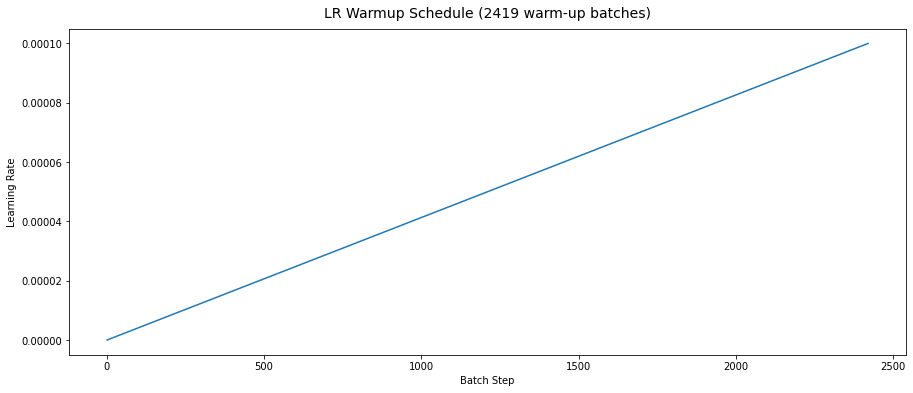


Ending LR: 0.0001


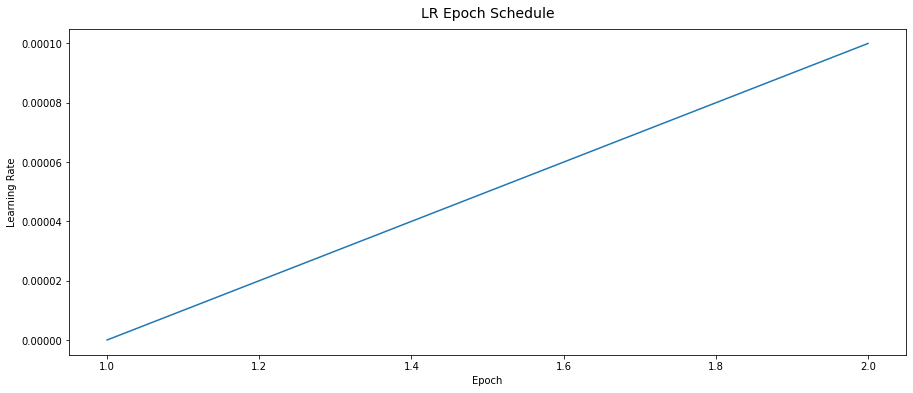

In [25]:
# simulate and plot the learning rates for training
if LR_DO_WARMUP_DECAY:
    if EPOCHS_CONTINUE['doit']:
        print('Continous training mode...')
        lr_epochs_continue = get_continous_training_lr_list(TRAIN_STEPS * WARMP_UP_EPOCHS)
        lrs_simple = LRSimpleScheduler(lr_epochs_continue)
        total_train_step = (EPOCHS_CONTINUE['epoch_end'] - EPOCHS_CONTINUE['epoch_start']) * TRAIN_STEPS
        lr_simple_epochs_simulated = lrs_simple.simulate_lr(total_train_step, TRAIN_STEPS)
    else:
        print('Nonstop training mode...')
        total_train_step = EPOCHS * TRAIN_STEPS
        lrs = LRScheduler(
                    warmup_batches      = TRAIN_STEPS * WARMP_UP_EPOCHS, 
                    lr_warmup_start     = LR_WARMUP_START, 
                    lr_warmup_end       = LR_WARMUP_END, 
                    lr_min              = LR_MIN,
                    decay_rate          = LR_DECAY_RATE_LINEAR,
                    verbose             = 0)
        
        lrs.simulate_lr(total_train_step, TRAIN_STEPS)
else:
    print('Warning: No learning rate decay is scheduled...')

## Corrections to HDF5 file 

Removing extra relative_attention_bias weight from .h5 file to incorporate Transformer 4.23 updates.

In [12]:
import h5py
path = '/content/gdrive/Shareddrives/NLP - Op tASk/NLP NRot Improvement/numeric-t5/models/rc_exp_1_stage_3_5_e60_drop/model_train_end.h5'

with h5py.File(path, "a") as f:
    del f['decoder/drop_base_t5/decoder/block_._0/layer_._1/EncDecAttention/relative_attention_bias']
    f['decoder'].attrs['weight_names'] = np.delete(f['decoder'].attrs['weight_names'], 10)
    try:
        del f['decoder/drop_base_t5/decoder/block_._0/layer_._1/EncDecAttention/relative_attention_bias'].value
    except KeyError as err:
        # print(err)
        pass

print(os.path.getsize(path))

242303936


In [ ]:
# NOTE: Training can be performed on top of anotheran existing trained model. This
# is required for both "continuous training" and "stage training." Refer to the 
# global config section for more details on "continuous training" and "stage training."

# model loading configs
TRAIN_LOAD_MODEL = True
TRAIN_MODEL_PATH = '/content/gdrive/Shareddrives/NLP - Op tASk/NLP NRot Improvement/numeric-t5/models/rc_exp_1_stage_3_5_e60_drop/model_train_end.h5'

TRAIN_MODEL = 't5-small'


# ------------------------------------------------------------------------------
# BUILD MODEL

keras.backend.clear_session() 
with strategy.scope(): 
    if TRAIN_LOAD_MODEL:    
            model = DROPBaseT5.from_pretrained(TRAIN_MODEL)
            model.compile()  
            model.load_weights(TRAIN_MODEL_PATH)
    else:
        optimizer = keras.optimizers.Adam(learning_rate=LR_CONSTANT)
        model = DROPBaseT5.from_pretrained(T5_MODEL)
        model.compile(optimizer=optimizer)

# ------------------------------------------------------------------------------
# BUILD CALLBACKS

callbacks = []

# LR schedule
if LR_DO_WARMUP_DECAY:
    if EPOCHS_CONTINUE['doit']:
        # first, simulate the entire training schedule as if it is nonstop
        lr_epochs_continue = get_continous_training_lr_list(TRAIN_STEPS * WARMP_UP_EPOCHS)
        lr_epochs_simulated = lrs.simulate_lr(total_train_step, TRAIN_STEPS, False)

        # second, extract the learning rates from the simulated epochs 
        lr_epochs_continue = lr_epochs_simulated[
                                            EPOCHS_CONTINUE['epoch_start']-1:
                                            EPOCHS_CONTINUE['epoch_end']:
                                            1]

        # lastly, build the LR schedule for the current training
        lrs = LRSimpleScheduler(lr_epochs_continue)
    else:
        lrs = LRScheduler(
                    warmup_batches   = TRAIN_STEPS * WARMP_UP_EPOCHS, 
                    lr_warmup_start  = LR_WARMUP_START, 
                    lr_warmup_end    = LR_WARMUP_END, 
                    lr_min           = LR_MIN,
                    decay_rate       = LR_DECAY_RATE_LINEAR,
                    verbose          = 0)
    callbacks.append(lrs)

# callback to save best model 
time = datetime.utcnow().strftime(f'%m-%d-%H%M%S')
model_save_dir = f'{MODEL_SAVE_PATH}/{T5_MODEL}_{time}'
if SAVE_MODEL_CHECKPOINTS_LOCAL:
    os.mkdir(model_save_dir)
    checkpoint_path = f'{model_save_dir}/model_best_chkpt_' + 'e_{epoch:02d}_vl_{val_loss:.8f}.h5'

    if SAVE_MODEL_WEIGHTS_ONLY:
        options = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
    else:
        options = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")
    callback_checkpoint = keras.callbacks.ModelCheckpoint(
                                            filepath=checkpoint_path,
                                            save_weights_only=SAVE_MODEL_WEIGHTS_ONLY,
                                            monitor='val_loss',
                                            mode='min',
                                            save_best_only=SAVE_BEST_MODEL_ONLY,
                                            options=options,
                                            verbose=1)
    callbacks.append(callback_checkpoint)

# callback to render tensorboard
if SHOW_TENSORBOARD:
    # TENSORBOARD_LOG_PATH must a GCP storage bucket if the model is running on TPU
    callback_tensorboard = keras.callbacks.TensorBoard(
                                                log_dir=TENSORBOARD_LOG_PATH, 
                                                histogram_freq=1)
    callbacks.append(callback_tensorboard)

# callback for wandb tracker
if SHOW_WANDB:
    callback_wandb = wandb.keras.WandbCallback(
                                        monitor='val_loss',
                                        mode='min',
                                        save_model=SAVE_MODEL_CHECKPOINTS_WANDB,
                                        save_weights_only=SAVE_MODEL_WEIGHTS_ONLY)
    callbacks.append(callback_wandb)

# ------------------------------------------------------------------------------
# TRAINING

# NOTE: Do NOT specify batch_size!
# DOC: Integer or None. Number of samples per gradient update. If unspecified, 
# batch_size will default to 32. Do not specify the batch_size if your data is 
# in the form of datasets, generators, or keras.utils.Sequence instances (since 
# they generate batches).

# TRAIN_STEPS = math.ceil(DROP_TRAIN_EXAMPLE_COUNT / BATCH_SIZE)
# VALID_STEPS = math.ceil(DROP_DEV_EXAMPLE_COUNT / BATCH_SIZE)
train_steps = math.ceil(int(sum(max_ds_size)) / BATCH_SIZE)#DROP_TRAIN_EXAMPLE_COUNT / BATCH_SIZE)
valid_steps = math.ceil(DROP_DEV_EXAMPLE_COUNT / BATCH_SIZE)

tf.get_logger().setLevel("ERROR")
model.fit(
    x=train_ds, 
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    verbose=1)

if SAVE_TRAINED_MODEL:
    # save trained model
    model.save_weights(f'{model_save_dir}/model_train_end.h5') 

In [ ]:
model_save_name = 'musique_.h5'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

## Performance Evaluation
The section includes classes and codes used to evaluate the performance of the model according to the [DROP paper](https://allennlp.org/drop). 

In [27]:
class DropPerformanceMeasure:
    def __init__(self, tokenizer: transformers.PreTrainedTokenizer) -> None:
        self.__metric = DropEmAndF1()
        self.__parsed_examples = []
        self.__tokenizer = tokenizer
        self.__preds = {}
        self.__time = datetime.utcnow().strftime(f'%m%d%H%M%S')
        self.__csv_save_path= ''

    def load_parse_drop_json_for_eval(
                    self,
                    json_url: str = DROP_DEV_JSON, 
                    example_count: int = DROP_DEV_EXAMPLE_COUNT,
                    test_mode: bool = False) -> int:
        """ Parse Drop json and reconstruct the DROP dataset. 
        Returns:
            (int) Total number of examples parsed.
        """
        with open(json_url) as f:
            drop_dict = json.load(f)

            # examples = []
            input_ids                  = []
            attention_masks            = []
            answer_types               = []
            answer_dicts               = []
            validated_answers_dicts    = []
            query_ids                  = []
            print(f'Parsing "{json_url}"...')
            with tqdm(total=example_count) as pbar:
                for key, json_example in drop_dict.items():
                    context = json_example['passage']
                    for qa_dict in json_example['qa_pairs']:
                        question = qa_dict['question']
                        answer = qa_dict['answer']
                        _, answer_type = self.__parse_answer(qa_dict['answer'])
                        query_id = qa_dict['query_id']
                        if 'validated_answers' in qa_dict:
                            validated_answers = qa_dict['validated_answers']
                        else:
                            validated_answers = None
                        if answer is None:
                            print(f'Skip {query_id} due to None answer...')
                            continue

                        input_text = f"answer_me: {question} context: {context}"
                        encoded_query = self.__tokenizer(
                                                    input_text, 
                                                    return_tensors='tf', 
                                                    padding='max_length', 
                                                    truncation=True, 
                                                    max_length=ENCODER_MAX_LEN)

                        input_ids.append(encoded_query["input_ids"][0])                  
                        attention_masks.append(encoded_query["attention_mask"][0])            
                        answer_types.append(answer_type)               
                        answer_dicts.append(answer)               
                        validated_answers_dicts.append(validated_answers)    
                        query_ids.append(query_id)                  

                        pbar.update(1)

                        if test_mode:
                            # parse only one passge & its questions
                            break
        
        self.__parsed_examples = {
                'input_ids'                 : input_ids,
                'attention_mask'            : attention_masks,
                'answer_type'               : answer_types,
                'answer_dict'               : answer_dicts,
                'validated_answers_dict'    : validated_answers_dicts,
                'query_id'                  : query_ids
        }

        return len(input_ids)

    def __parse_answer(
                    self, 
                    answer_dict: dict, 
                    spans_sep_token: str = '<ss>') -> str:
        """Parse the answer json node to string. Spans answers will be seperated 
        using spans_sep_token.
        """
        number = answer_dict['number'].strip()
        if number:
            return number, 'n'
        
        spans = answer_dict['spans']
        spans_str = spans_sep_token.join([span.strip() for span in spans if span.strip()])
        if spans_str:
            if len(spans) > 1:
                return spans_str, 's'
            else:
                return spans_str, 'ss'
        
        date = answer_dict['date']
        if len(date) != 3:
            return None, None
        date = ' '.join([d.strip() for d in [date['day'], date['month'], date['year']] if d.strip()])
        if date:
            return date, 'd'
        
        return None, None
    
    def __parse_validated_answers(
                        self, 
                        validated_answers: list, 
                        sep_token: str = '<sv>') -> str:
        """Parse validated_answers json node to string using sep_token.
        """
        if validated_answers is None:
            return ''

        answers = []
        for answer_dict in validated_answers:
            ans, _ = self.__parse_answer(answer_dict)
            answers.append(ans)
        return sep_token.join([a.strip() for a in answers if a.strip()])

    def __to_tf_dataset(
            self,
            parsed_examples: dict, 
            max_len: int = 512,
            batch_size: int = BATCH_SIZE,
            test_reduce_data: bool = False) -> tf.data.Dataset:
        # convert to hugging face ds
        ds = datasets.Dataset.from_dict(parsed_examples)
        if test_reduce_data:
            test_ds = datasets.Dataset.from_dict(test_ds[:10])
            test_quids = test_quids[:10]
        
        # convert to tf ds
        columns = [
                'input_ids', 
                'attention_mask']
        ds.set_format(type='tensorflow', columns=columns)
        ds_tf = {x: ds[x]
                        for x in [
                            'input_ids', 
                            'attention_mask']}        
        ds_tf = tf.data.Dataset.from_tensor_slices(ds_tf)
        ds_tf = ds_tf.repeat(1)
        ds_tf = ds_tf.batch(batch_size)
        ds_tf = ds_tf.prefetch(tf.data.experimental.AUTOTUNE)

        return ds_tf

    def predict(
            self,
            model: transformers.TFT5ForConditionalGeneration, 
            ds_example_count: int = 0,
            decoder_max_len: int = DECODER_MAX_LEN,
            batch_size: int = BATCH_SIZE,
            dry_run: bool = False) -> dict:
        """Predict and decode using the trained T5 model.
        Refs:
            https://tinyurl.com/yxlr4jmb
            https://tinyurl.com/y53l7vfm
        Returns:
            (tuple) (preds, labels, types)
        """
        if len(self.__parsed_examples) == 0:
            return None
        
        def fix_output_spacing(s: str) -> str:
            """Fixing the odd bug that numerical numbers are losing a whitespace in 
            front after adding digits to special tokens.
            """
            match = re.compile(r'([a-z]|,|-)(\d)')
            s = re.sub(match, r'\1 \2', s)
            match = re.compile(r'(\d|[a-z])( )?(-)( )?(\d|[a-z])')
            s = re.sub(match, r'\1\3\5', s)
            return s

        ds = self.__to_tf_dataset(self.__parsed_examples, batch_size=batch_size)        
        with tqdm(total=ds_example_count) as pbar:
            inputs, preds = [], []
            for batch in ds:
                outs_pred = model.generate(
                                input_ids=batch['input_ids'], 
                                attention_mask=batch['attention_mask'],
                                max_length=decoder_max_len)
                
                # detokenize and fix the output whitespace bug in front of numbers
                outs_pred = [fix_output_spacing(self.__tokenizer.decode(ids))
                             for ids in outs_pred]
                preds.extend(outs_pred)

                # inputs
                ins = batch['input_ids']
                ins = [self.__tokenizer.decode(input) for input in ins]
                inputs.extend(ins)

                # update progress bar
                pbar.update(len(batch['input_ids']))
                if dry_run:
                    # process only one batch if dry run
                    break
                    
        self.__preds['inputs'] = inputs
        self.__preds['predictions'] = preds
        self.__preds['answer_dict'] = self.__parsed_examples['answer_dict']
        self.__preds['answer_type'] = self.__parsed_examples['answer_type']
        self.__preds['query_id'] = self.__parsed_examples['query_id']
        self.__preds['validated_answers_dict'] = self.__parsed_examples['validated_answers_dict']

        return self.__preds

    def evaluate(
            self, 
            query_id: list,
            answer_dict: list,
            validated_answers_dict: list,
            answer_type: list,
            predictions: list,
            prediction_spans_sep_token: str = '<ss>',
            print_reports: bool = True) -> tuple:
        """Evaluate a batch.
        Refs:
            https://tinyurl.com/yyuuvc5b
            https://tinyurl.com/y6rmrp85
        """
        metric_overall = DropEmAndF1()
        errors = []
        for qid, ans, ans_validated, ans_type, pred in zip(
                                                query_id,
                                                answer_dict, 
                                                validated_answers_dict,
                                                answer_type,
                                                predictions):
            # build predction for evaluation
            if ans_type == 's': # spans answer
                prediction_parsed = pred.split(prediction_spans_sep_token)
            else:
                prediction_parsed = pred

            # build truths for evaluation
            ground_truths = [ans]
            if ans_validated is not None:
                ground_truths.extend(ans_validated)
            
            # track performance per example
            metric_example = DropEmAndF1()
            metric_example(prediction=prediction_parsed, ground_truths=ground_truths)
            example_exact_match, exampe_f1_score = metric_example.get_metric()
            
            ans_parsed, _ = self.__parse_answer(ans)
            ans_val = self.__parse_validated_answers(ans_validated)
            
            # add to error report
            if exampe_f1_score < 1:
                example_error = {
                        'query_id'          : qid,
                        'prediction'        : pred,
                        'answer'            : ans_parsed,
                        'validated_answers' : ans_val,
                        'f1'                : exampe_f1_score,
                        'exact_match'       : example_exact_match
                }
                errors.append(example_error)

            # update metrics
            metric_overall(prediction=prediction_parsed, ground_truths=ground_truths)

        exact_match, f1_score = metric_overall.get_metric()
        return exact_match, f1_score, errors
    
    def evaluate_by_type(
                    self, 
                    prediction_spans_sep_token: str = '<ss>',
                    print_reports: bool = True,
                    error_print_count: int = 100,
                    save_dir: str = None) -> tuple:
        """Evaluate the performance by question type.
        """
        predictions     = np.array(self.__preds['predictions'])
        types           = np.array(self.__preds['answer_type'])
        qids            = np.array(self.__preds['query_id'])
        inputs          = np.array(self.__preds['inputs'])
        answer_dict     = np.array(self.__preds['answer_dict'])
        vals            = np.array(self.__preds['validated_answers_dict'])
        
        types   = types.reshape(types.shape[0])
        qids    = qids.reshape(qids.shape[0])
        inputs  = inputs.reshape(inputs.shape[0])

        types_n     = types=='n'
        types_d     = types=='d'
        types_ss    = types=='ss'
        types_s     = types=='s'

        types_n     = types_n.reshape(types_n.shape[0])
        types_d     = types_d.reshape(types_d.shape[0])
        types_ss    = types_ss.reshape(types_ss.shape[0])
        types_s     = types_s.reshape(types_s.shape[0])

        number_eval = self.evaluate(
                        qids[types_n].tolist(),
                        answer_dict[types_n].tolist(),
                        vals[types_n].tolist(),
                        types[types_n].tolist(),
                        predictions[types_n].tolist(),
                        prediction_spans_sep_token=prediction_spans_sep_token)

        date_eval = self.evaluate(
                        qids[types_d].tolist(),
                        answer_dict[types_d].tolist(),
                        vals[types_d].tolist(),
                        types[types_d].tolist(),
                        predictions[types_d].tolist(),
                        prediction_spans_sep_token=prediction_spans_sep_token)
        span_eval = self.evaluate(
                        qids[types_ss].tolist(),
                        answer_dict[types_ss].tolist(),
                        vals[types_ss].tolist(),
                        types[types_ss].tolist(),
                        predictions[types_ss].tolist(),
                        prediction_spans_sep_token=prediction_spans_sep_token)
        spans_eval = self.evaluate(
                        qids[types_s].tolist(),
                        answer_dict[types_s].tolist(),
                        vals[types_s].tolist(),
                        types[types_s].tolist(),
                        predictions[types_s].tolist(),
                        prediction_spans_sep_token=prediction_spans_sep_token)
        
        evals_cat = {
            'number'    : {'exact_match': number_eval[0], 'f1': number_eval[1]},
            'date'      : {'exact_match': date_eval[0], 'f1': date_eval[1]},
            'span'      : {'exact_match': span_eval[0], 'f1': span_eval[1]},
            'spans'     : {'exact_match': spans_eval[0], 'f1': spans_eval[1]}
        }
        errors_cat = {
            'number'    : number_eval[2],
            'date'      : date_eval[2],
            'sapn'      : span_eval[2],
            'spans'     : spans_eval[2]
        }

        # generate reports
        print('\n\n')
        print('CATEGORY PERFORMANCE')
        df_cat = pd.DataFrame(evals_cat)
        display(df_cat)

        print('\n\n')
        print('ERROR ANALYSIS')
        for item in errors_cat.items():
            q_type = item[0]
            
            # print
            print(f'Question Type: {q_type.capitalize()}')
            df = pd.DataFrame(item[1])
            if df.shape[0] > error_print_count:
                df_sample = df.sample(n=error_print_count)
            else:
                df_sample = df
            display(df_sample)
            print('\n')

            # save
            if save_dir is not None:
                path = f'{self.__csv_save_path}/{save_dir}/performace_reports_{self.__time}'
            else:
                path = f'{self.__csv_save_path}/performace_reports_{self.__time}'
            os.makedirs(path, exist_ok=True)
            df_cat.to_csv(f'{path}/performance_category.csv')
            df_sample.to_csv(f'{path}/ea_{q_type}_sample_{df_sample.shape[0]}.csv')
            df.to_csv(f'{path}/ea_{q_type}_full_{df.shape[0]}.csv')
        
        print(f"\nError reports have been saved to {path}!")

        return evals_cat, errors_cat

    def __get_errors(
                self,
                predictions: np.ndarray,
                truths: np.ndarray,
                qids: np.ndarray,
                inputs: np.ndarray) -> dict:
        filter_ = predictions != truths
        return {
            'query_ids': qids[filter_],
            'predictions': predictions[filter_], 
            'truths': truths[filter_],
            'inputs': inputs[filter_]}

    def evaluate_all(
                self, 
                save_dir: str = None,
                prediction_spans_sep_token: str = '<ss>') -> None:
        exact_match, f1_score, _ = self.evaluate(
                                        self.__preds['query_id'], 
                                        self.__preds['answer_dict'], 
                                        self.__preds['validated_answers_dict'],
                                        self.__preds['answer_type'],
                                        self.__preds['predictions'],
                                        prediction_spans_sep_token=prediction_spans_sep_token)
        """Evaluate the performance across the entire dataset.
        """
        # generate eval report
        print('')
        print('OVERALL PERFORMANCE')
        evals_overall = {'exact_match': exact_match, 'f1': f1_score}
        df_overall = pd.DataFrame(evals_overall, index=[0])
        display(df_overall.style.hide_index())

        # save report
        if save_dir is not None:
            path = f'{self.__csv_save_path}/{save_dir}/performace_reports_{self.__time}'
            
        else:
            path = f'{self.__csv_save_path}/performace_reports_{self.__time}'
        os.makedirs(path, exist_ok=True)
        df_overall.to_csv(f'{path}/performance_overall.csv')

    def get_eval_reports(
                    self, 
                    csv_save_path: str,
                    prediction_spans_sep_token: str = '<ss>',
                    print_reports: bool = True,
                    grouping_dir: str = None) -> None:
        """Function to produce the performance evaluation report.
        Args:
            csv_save_path: Path to the folder where the reports will be saved to.
            prediction_spans_sep_token: Token used to separate the different answers for spans.
            print_reports: Set true to print sample reports in the notebook.
            grouping_dir: Optional; folder to be created under csv_save_path for saving the reports.
        """
        self.__csv_save_path = csv_save_path
        self.evaluate_all(
                    save_dir=grouping_dir, 
                    prediction_spans_sep_token=prediction_spans_sep_token)
        self.evaluate_by_type(
                    save_dir=grouping_dir,
                    prediction_spans_sep_token=prediction_spans_sep_token)
    
    def reset(self) -> None:
        self.__metric = DropEmAndF1()
        self.__parsed_examples = []

In [ ]:
if EVALUATE_DEV:
    PRED_LOAD_MODEL = True
    PRED_MODEL = 't5-small'
    PRED_MODEL_PATH = f'{GDRIVE_REPO_PATH}/musique_evaluation/musique_model_train_end.h5'
    EVAL_REPORT_SAVE_PATH = f'{GDRIVE_REPO_PATH}/musique_evaluation/error_reports/'

    if PRED_LOAD_MODEL:
        keras.backend.clear_session() 
        with strategy.scope(): 
            model_pred = DROPBaseT5.from_pretrained(TRAIN_MODEL)
            model_pred.compile()
            model_pred.load_weights(TRAIN_MODEL_PATH)
    else:
        model_pred = model

    dev_eval = DropPerformanceMeasure(TOKENIZER)
    count = dev_eval.load_parse_drop_json_for_eval(test_mode=False)
    print(f'Total number of examples to be evaluated: {count}')
    dev_eval.predict(
                model=model_pred, 
                # batch_size=10, # only required if dry_run = True
                ds_example_count=DROP_DEV_EXAMPLE_COUNT,
                dry_run=False)
    dev_eval.get_eval_reports(
                csv_save_path=EVAL_REPORT_SAVE_PATH,
                prediction_spans_sep_token='<ss>')